# Summary

## inputs
This notebook has three inputs:
1. Raw data -  NFL **nflplaybyplay2009to2016** having many rows per game - each row is a 'play' in the games
2. A **dimensions** dataset from my initial review of the data - this categorizes each column by how it should be treated

## the data
The gameplay data has many nulls(), but they make sense once we recognize that not every field is applicable for every type of play.
for example,
> If a row represents a passing play, then the rushing data does not make sense, so it's all null
> The passing data is only relevant for passing plays, otherwise it's not applicable, so it's null in our data
>
> Analytics data is not null, but it's not something we'll always want, so it should also be considered a separate data set of data
> Any data that we segment out, should be able to be joined back together.

so this is a bit like a **fact** and **dimensions** model, where certain colums are core facts, and other are really dimensions that are only relevant under certain circumstatnces

## goal
To create datasets that might not yet be completely prepared for ML, but can be queried for many uses, including ML

## cleanup
1. Separate the data into core **facts** - these are columns that apply to every play, and should never be null
2. Create a separate dataset for all the **dimensions** columns that are only good for specific kinds of plays
3. Add in facts that are inferred by the sparse dimensions columns, but don't explicitly exist as facts:
> for example:
>     If there was a defensive two point conversion - the def_two_point will be non-null
>           but it is null for every other case
>           see we create a def_two_point_key that is always 1 or 0 in the fact table
>           and we move def_two_point the dimensions
> There are cases where we could just fill the def_two_point with 'Not Applicable' when it's null,
> but that's not ging to solve every issue
>
4. Identify boolean keys that are important pivots in the facts table:
    (a) whether a pass was attempted
    (b) whether a RUSH was attempted
    (c) whether there was a penalty on the play
    (d) an offensive or defensive two point conversion
    (e) whether there was a sack
    (f) whether a pass was attempted
 ... and more...

## outputs
1. A cleaned NFL `gameplay` dataset - having many rows per game - each row is a 'play' in the games
2. A column-level metrics dataset that holds some key metrics from describe(), dtypes, etc. and also some configurations


## metrics
We create a metrics dataset that's really nothing more than the results of pandas functions, such as describe()
and some math and logic.

I like to have it in a separate dataset that I can annotate, and extend with configurations for each column
that can be used in further processing

Initially there are a lot of columns with 'poor' completeness, but that's because many fields are dimensions (see above).

<img align="left" src="metrics_raw.png" width="1000">

# 01 - Prepare

## 01.1 - imports

In [71]:
%load_ext autoreload
%load_ext dotenv
%dotenv
%autoreload 2

import warnings

import numpy as np
import pandas as pd
import os
import sys
from matplotlib import pyplot as plt

warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

pd.set_option('display.float_format', lambda x: '%.5f' % x)

np.random.seed(0)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The dotenv extension is already loaded. To reload it, use:
  %reload_ext dotenv


In [72]:
module_path = os.path.abspath(os.path.join('../src'))
print("Adding modules", module_path)
if module_path not in sys.path:
    sys.path.append(module_path)

Adding modules /Users/christopherlomeli/Source/courses/datascience/nfl_capstone/src


In [73]:
from src.features.wrangling.database_loader import DatabaseLoader
from src.features.wrangling.get_metrics import GetMetrics, get_versioned_name, conform_column_names, plot_missing
from src.data.s3utils import parquet_to_s3

## 01.2 - setup

In [94]:
NFL_SEASONS_START=2018
NFL_SEASONS_LAST=2022
#-----

NFL_SEASONS=list(range(NFL_SEASONS_START, NFL_SEASONS_LAST+1,1))

RAW_DATA_PATH = '../data/raw'
INTERIM_DATA_PATH='../data/interim'
USE_CONNECTION="DB_CONNECTION_URL"   # DB_FILENAME_URL for csv or DB_CONNECTION_URL for postgres

# inputs
DIMENSIONS_DATA = os.path.join(RAW_DATA_PATH,"dimensions.csv")

#outputs
l =  len(NFL_SEASONS)
id = f"{NFL_SEASONS[0]}"
if l > 1:
    id = f"{id}-{NFL_SEASONS[-1]}"

OUTPUT_DATA = os.path.join(INTERIM_DATA_PATH,f"nflverse.{id}.reviewed.parquet")
READ_ME = os.path.join(INTERIM_DATA_PATH,"READ_ME.01-cjl-review.csv")

# database
METRICS_TABLE_NAME="nfl_metrics"
CATEGORIES_TABLE_NAME="nfl_categories"

# verify
print("OUTPUT_DATA", OUTPUT_DATA )
print("", DIMENSIONS_DATA)
print("DIMENSIONS_DATA", METRICS_TABLE_NAME)
print("CATEGORIES_TABLE_NAME", CATEGORIES_TABLE_NAME)


OUTPUT_DATA ../data/interim/nflverse.2018-2022.reviewed.parquet
 ../data/raw/dimensions.csv
DIMENSIONS_DATA nfl_metrics
CATEGORIES_TABLE_NAME nfl_categories


In [95]:
NFL_SEASONS

[2018, 2019, 2020, 2021, 2022]

In [75]:
db = DatabaseLoader(connection_string_env_url=USE_CONNECTION)

## 01.3 - download raw data from NFLVerse

In [76]:
import nfl_data_py as nfl
data_df = nfl.import_pbp_data(NFL_SEASONS,  downcast=True, cache=False)

2018 done.
2019 done.
Downcasting floats.


# 03 - Metrics

## 03.1 - get metrics

In [77]:
metrics = GetMetrics()

In [78]:
dimensions_df = pd.DataFrame()

try:
    dimensions_df = pd.read_csv(DIMENSIONS_DATA)
except Exception:
    pass

dimensions_df.head()

,column_name,feature_type,c_dimension
0,wp,analytics,dimension
1,total_away_epa,analytics,dimension
2,total_home_comp_yac_epa,analytics,dimension
3,total_home_raw_yac_wpa,analytics,dimension
4,vegas_home_wpa,analytics,dimension


In [79]:
metrics_df = metrics.get_metrics(data_df, dimensions_df)

In [80]:
metrics_df.quality.value_counts()

poor       163
good       117
perfect    104
Name: quality, dtype: int64

In [81]:
metrics_df[metrics_df.data_type == 'float64']

,data_type,unique_counts,feature_type,c_dimension,row_count,good_count,missing_count,completeness,quality,mean,std,min,max,median,top,freq
column_name,,,,,,,,,,,,,,,,


## 03.2 - get categories

In [82]:
categories = metrics.get_categories(data_df=data_df, unique_count_threshold=40)

# 04 - Inspection
## 04.1 - Histograms of all non-null, numeric elements

Quick cursory look at distributions of all columns - we'll refine this later
Some have good distribution, but there are many nulls - so some of these distributions only apply to a non-null subset of the data


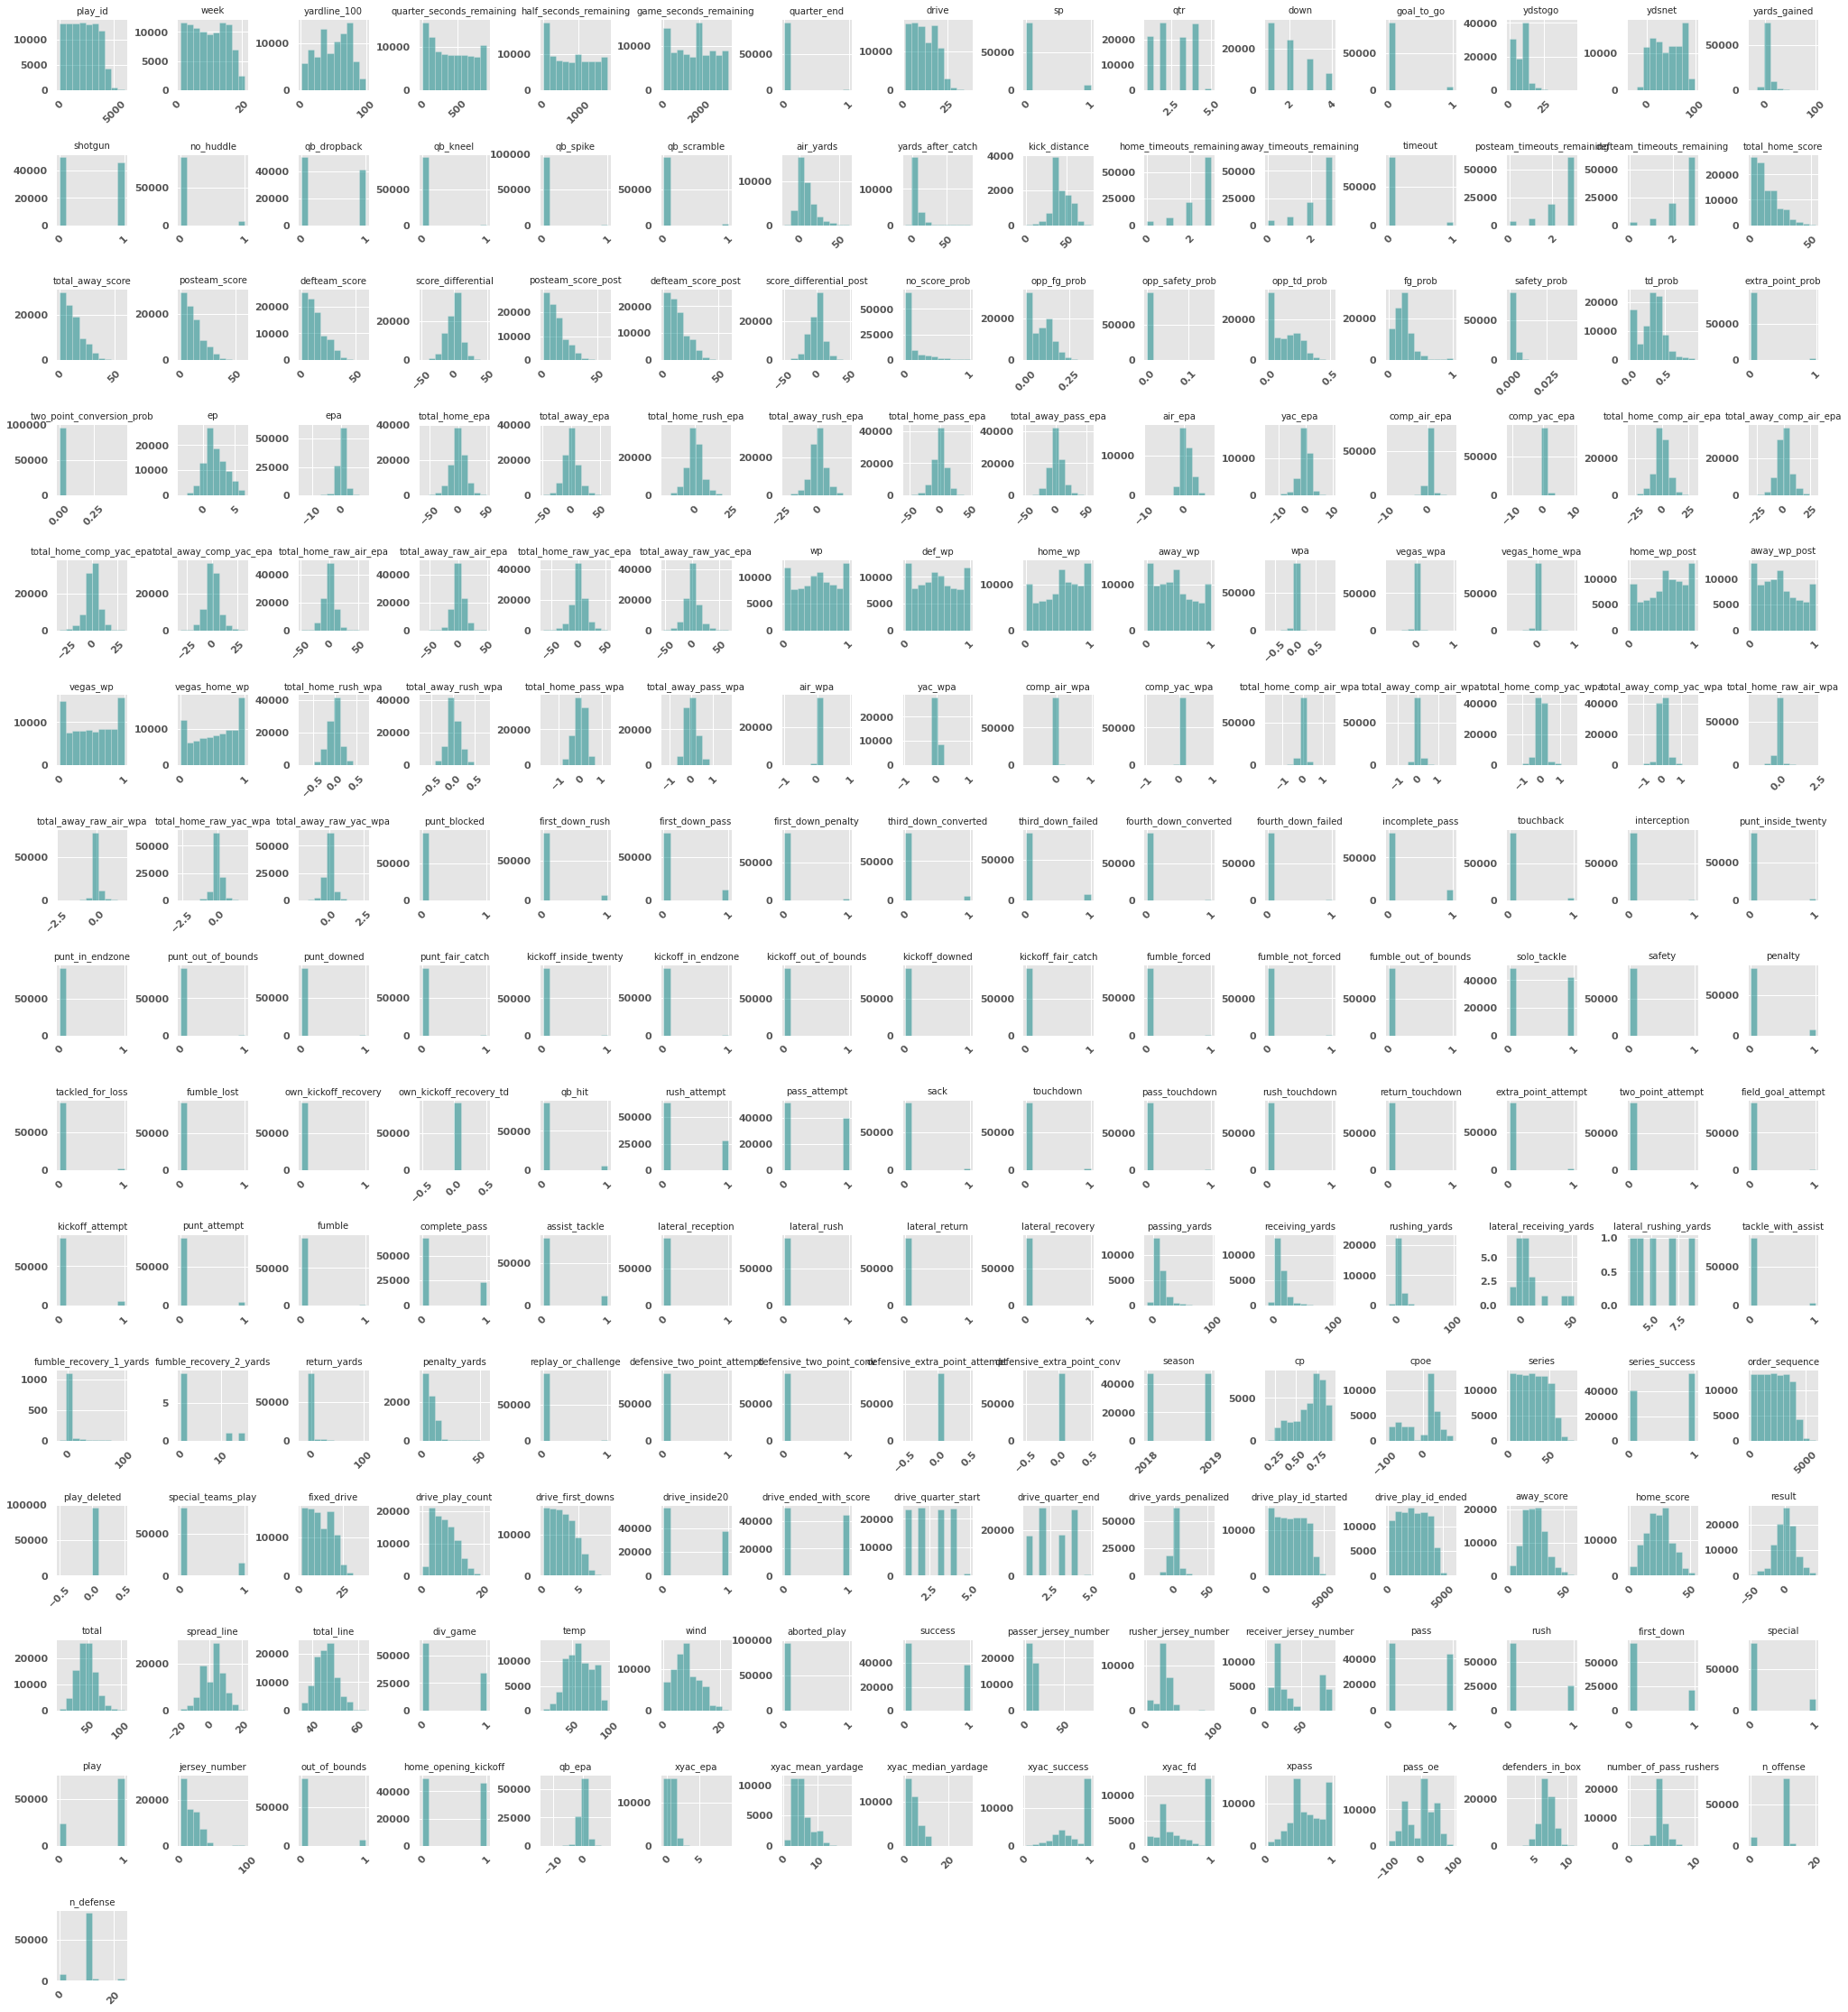

In [105]:
print("Quick cursory look at distributions of all columns - we'll refine this later")
print("Some have good distribution, but there are many nulls - so some of these distributions only apply to a non-null subset of the data")

# font = {'family' : 'DejaVu Sans',
#         'size'   : 5}
#
# plt.rc('font', **font)

plt.style.use('ggplot')
plt.rcParams['font.size'] = 7
data_df.hist(figsize=(35,40), xrot=45, color='teal', alpha=.5)
plt.subplots_adjust(hspace=.9, wspace=.7);

## 04.2 - overview of completeness (non-null data per column)

Showing only the columns that have at least some missing data


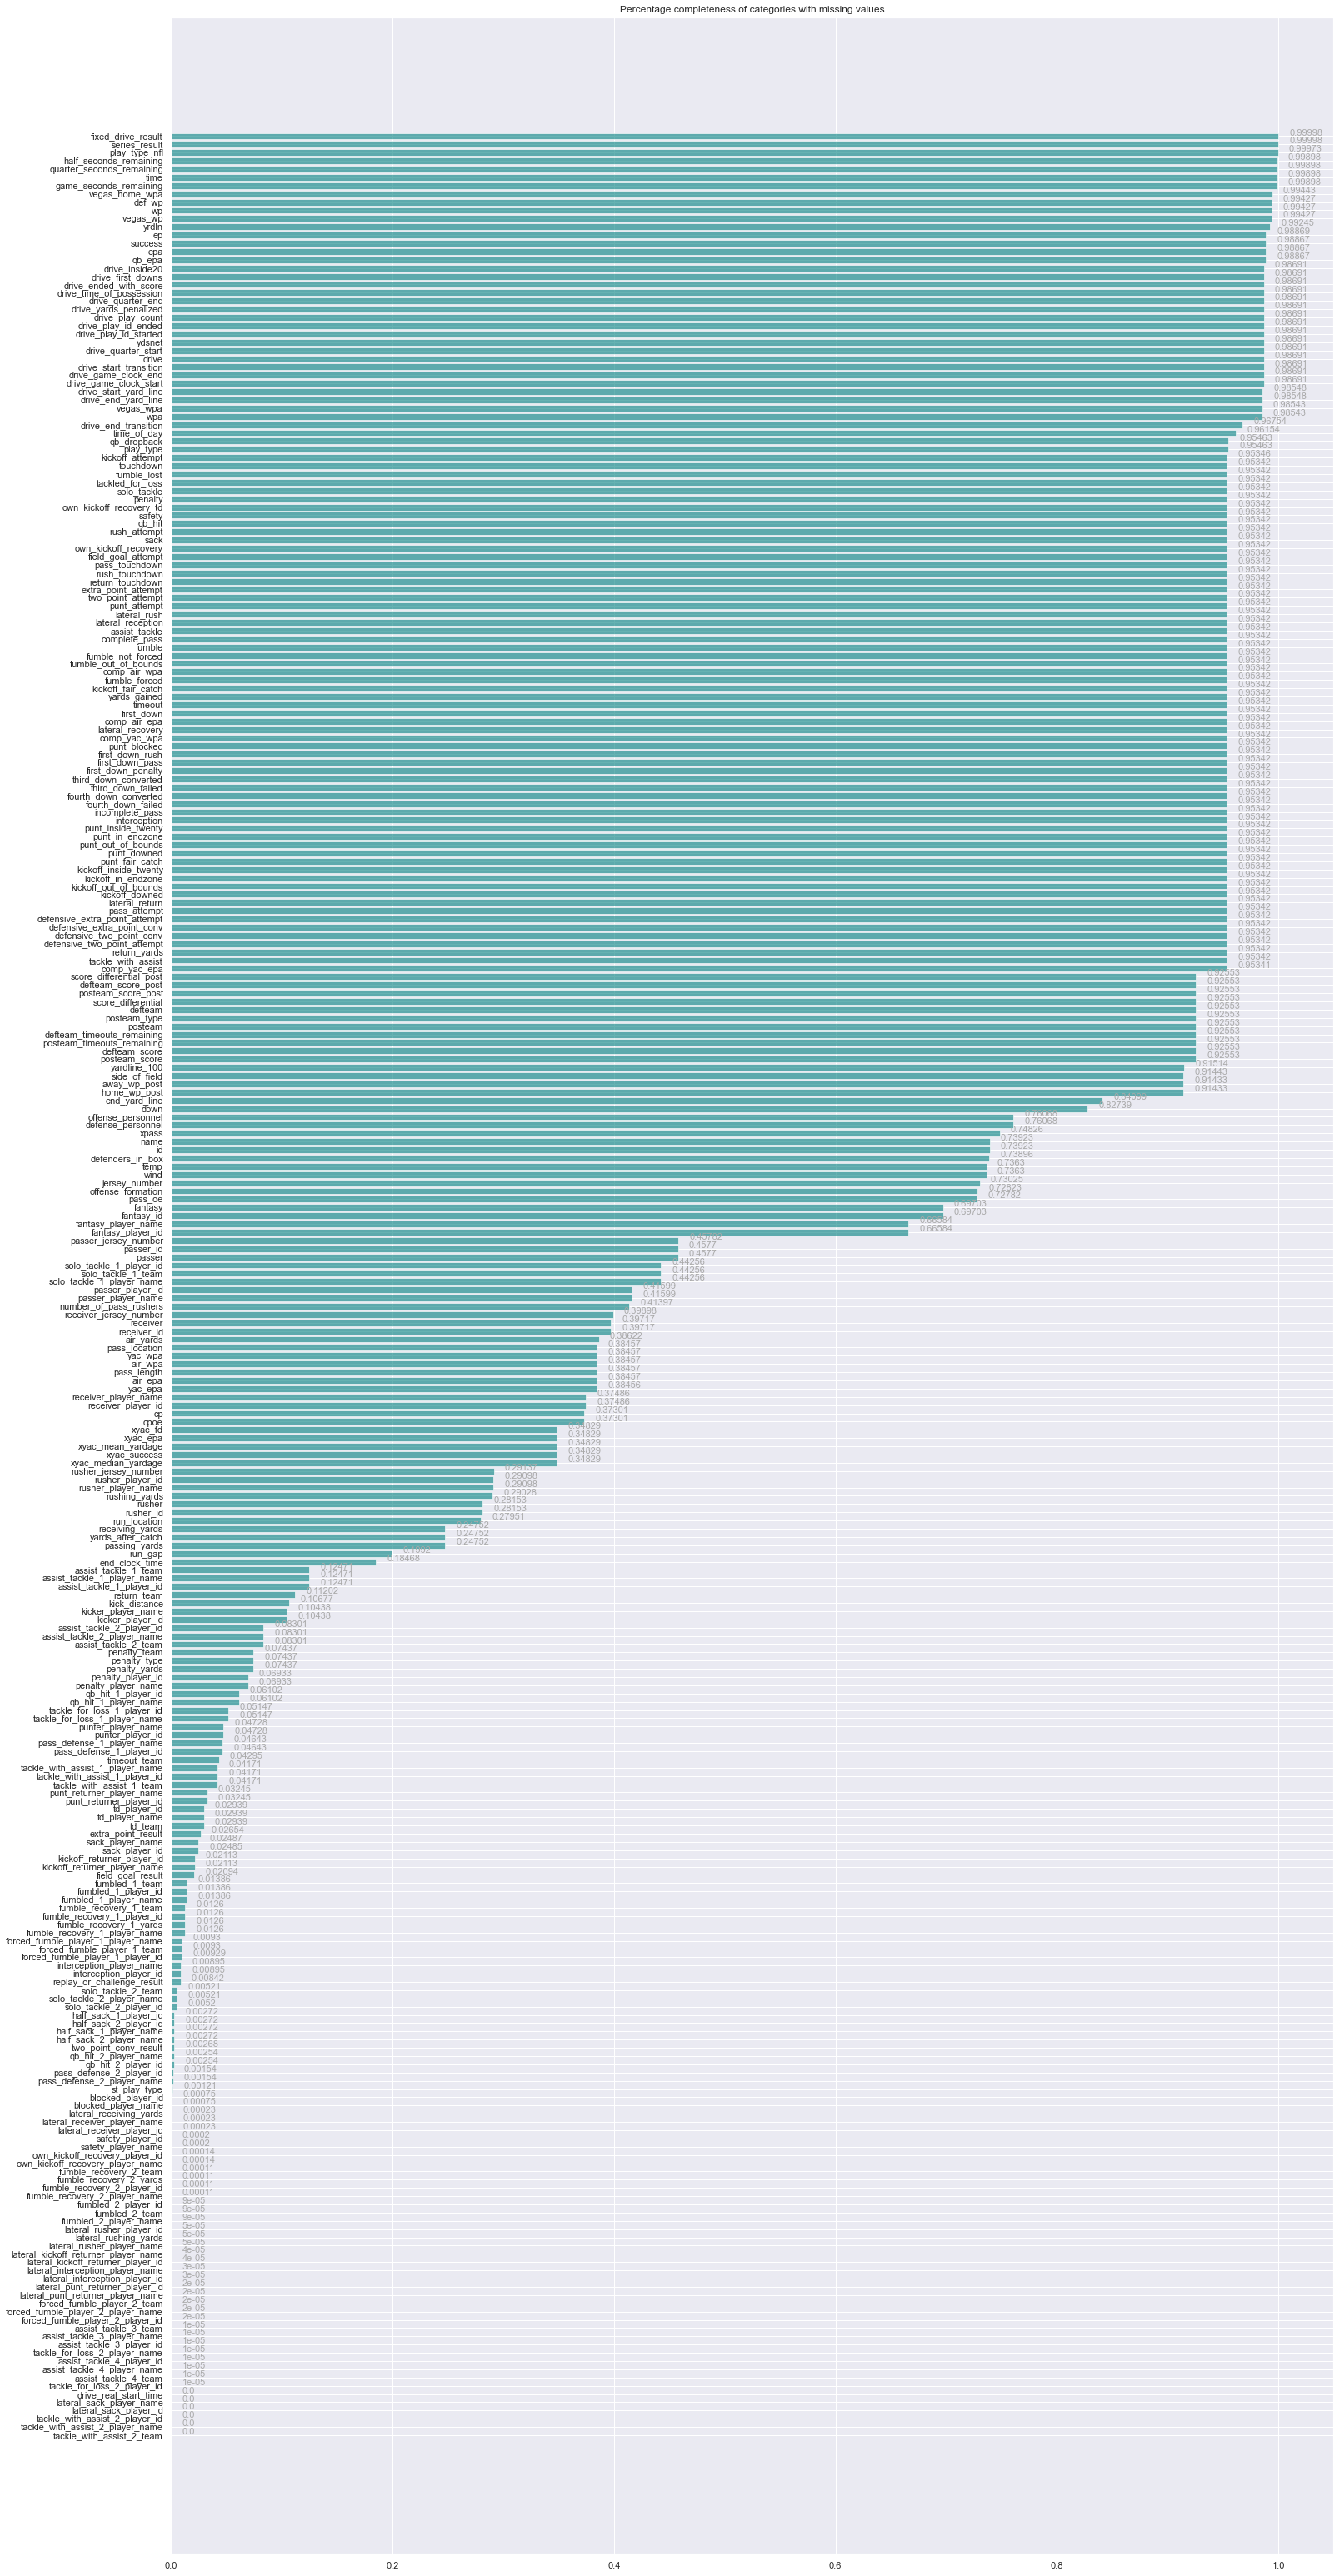

In [84]:
from src.features.wrangling.get_metrics import plot_missing

print("Showing only the columns that have at least some missing data")
plot_missing(metrics_df, missing_only=True)

# 05 - Save our results

## 05.1 - save metric backup to disk

In [85]:
print("Writing data to local path:",OUTPUT_DATA)
data_df.to_parquet(OUTPUT_DATA, engine='fastparquet',  compression='snappy')

Writing data to local path: ../data/interim/nflverse.2018-2019.reviewed.parquet


In [86]:
if not os.path.exists(READ_ME):
    print("Writing readme to local path:",READ_ME)

    pd.DataFrame([
        {'file': os.path.basename(OUTPUT_DATA), 'desc': 'reviewed and slightly modified gameplay data - no longer raw'},
        {'file': os.path.basename(METRICS_TABLE_NAME), 'desc': 'optional - when we save the metrics to a file instead of a database'},
        {'file': os.path.basename(CATEGORIES_TABLE_NAME), 'desc': 'optional - when we save the categories to a file instead of a database'}
    ]).to_csv(READ_ME, index=False)
else:
    print(READ_ME, " already exists")


../data/interim/READ_ME.01-cjl-review.csv  already exists


## 05.2 - load metrics to db
Why load to a database? because it's easier (for me) to explore and annotate the data from an IDE
that is capable of datagrids and quick ad-hoc query

In [87]:

db.load_table(metrics_df, METRICS_TABLE_NAME)
print('Created',METRICS_TABLE_NAME)

db.load_table(categories, CATEGORIES_TABLE_NAME)
print('Created',CATEGORIES_TABLE_NAME)

Created nfl_metrics
Created nfl_categories
